In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import datetime as dt
import sys
import os
import pandas as pd
import os.path as osp
import xarray as xr
from copy import copy
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from cartopy.geodesic import Geodesic
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import datetime
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.io.img_tiles as cimgt
import pytz
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
oco_data_folder = '/Users/agmeyer4/LAIR_1/Data/OCO/OCO2/'
oof_data_folder = '/Users/agmeyer4/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_oof_v2_nasrin_correct/'
map_extent={'lon_low':-112.4,
            'lon_high':-111.6,
            'lat_low':40.5,
            'lat_high':41.0}

inst_loc = {'lat':40.768,'lon':-111.854}
radius = 6000
oof_surround_time = datetime.timedelta(minutes=30)

oco_filename = 'oco2_LtCO2_221003_B11100Ar_230609093747s.nc4'
oof_filename = 'ha20221003.vav.ada.aia.oof'

In [18]:
class oof_manager:
    '''Class to manage getting data from oof files'''

    def __init__(self,oof_data_folder,timezone):
        '''
        Args: 
        oof_data_folder (str) : path to the folder where oof data is stored
        timezone (str) : timezone for the measurments
        '''
        self.oof_data_folder = oof_data_folder
        self.timezone = timezone

    def load_oof_df_inrange(self,dt1,dt2,filter_flag_0=False):
        '''Loads a dataframe from an oof file for datetimes between the input values
        
        Args:
        dt1_str (str) : string for the start time of the desired range of form "YYYY-mm-dd HH:MM:SS" 
        dt2_str (str) : string for the end time of the desired range of form "YYYY-mm-dd HH:MM:SS" 
        oof_filename (str) : name of the oof file to load
        filter_flag_0 (bool) : True will filter the dataframe to rows where the flag column is 0 (good data), false returns all the data

        Returns:
        df (pd.DataFrame) : pandas dataframe loaded from the oof files, formatted date, and column names       
        '''
        if type(dt1) == str:
            dt1 = self.tzdt_from_str(dt1)
            dt2 = self.tzdt_from_str(dt2)
        oof_files_inrange = self.get_oof_in_range(dt1,dt2)
        full_df = pd.DataFrame()
        for oof_filename in oof_files_inrange:
            df = self.df_from_oof(oof_filename) #load the oof file to a dataframe
            df = self.df_dt_formatter(df) #format the dataframe to the correct datetime and column name formats
            df = df.loc[(df.index>=dt1)&(df.index<=dt2)] #filter the dataframe between the input datetimes
            if filter_flag_0: #if we want to filter by flag
                df = df.loc[df['flag'] == 0] #then do it!
            full_df = pd.concat([full_df,df])
        return full_df

    def tzdt_from_str(self,dt_str):
        '''Apply the inherent timezone of the class to an input datetime string
        
        Args:
        dt_str (str) : datetime string of form "YYYY-mm-dd HH:MM:SS" 
        
        Returns:
        dt (datetime.datetime) : timezone aware datetime object, with timezone determined by the class
        '''

        dt = datetime.datetime.strptime(dt_str,'%Y-%m-%d %H:%M:%S') #create the datetime
        dt = pytz.timezone(self.timezone).localize(dt) #apply the timezone
        return dt

    def df_from_oof(self,filename,fullformat = False,filter_flag_0 = False):
        '''Load a dataframe from an oof file
        
        Args:
        filename (str) : name of the oof file (not the full path)
        fullformat (bool) : if you want to do the full format
        
        Returns:
        df (pd.DataFrame) : a pandas dataframe loaded from the em27 oof file with applicable columns added/renamed
        '''

        oof_full_filepath = os.path.join(self.oof_data_folder,filename) #get the full filepath using the class' folder path
        df = pd.read_csv(oof_full_filepath,header = self.read_oof_header_line(oof_full_filepath),delim_whitespace=True,skip_blank_lines=False) #read it as a csv, parse the header
        df['inst_zasl'] = df['zobs(km)']*1000 #add the instrument z elevation in meters above sea level (instead of km)
        df['inst_lat'] = df['lat(deg)'] #rename the inst lat column
        df['inst_lon'] = df['long(deg)'] #rename the inst lon column 
        if fullformat:
            df = self.df_dt_formatter(df)
        if filter_flag_0:
            df = df.loc[df['flag']==0]
        return df

    def read_oof_header_line(self,full_file_path):
        '''Reads and parses the header line of an oof file
        
        Args: 
        full_file_path (str) : full path to an oof file we want to read
        
        Returns:
        header (list) : list of column names to use in the header 
        '''

        with open(full_file_path) as f: #open the file
            line1 = f.readline() #read the first line
        header = int(line1.split()[0])-1 #plit the file and get the header
        return header

    def parse_oof_dt(self,year,doy,hr_dec):
        '''Get a real datetime from an oof style datetime definition
        
        Args:
        year (int) : year
        doy (int) : day of the year 
        hr_dec (float) : decimal hour of the day
        
        Returns:
        dt (pandas.datetime) : pandas datetime object gleaned from the inputs
        '''

        dt = pd.to_datetime(f'{int(year)} {int(doy)}',format='%Y %j') + datetime.timedelta(seconds = hr_dec*3600)
        return dt

    def df_dt_formatter(self,df):
        '''Format a loaded oof dataframe to have the correct datetime as an index

        Assumes that the oof timestamps are in UTC
        
        Args: 
        df (pd.DataFrame) : dataframe loaded using df_from_oof() 

        Returns:
        df (pd.DataFrame) : reformatted dataframe with datetime as the index, and converted to a timezone aware object. 
        '''

        df['dt'] = np.vectorize(self.parse_oof_dt)(df['year'],df['day'],df['hour']) #set the datetime column by parsing the year, day and hour columns
        df = df.set_index('dt',drop=True).sort_index() #set dt as the index
        df.index = df.index.tz_localize('UTC').tz_convert(self.timezone) #localize and convert the timezone
        return df

    def get_sorted_oof(self):
        '''Get a list of oof files in the oof data folder, sorted so they are in chron order
        
        Returns:
        files (list) : list of files ending in oof in the data folder
        '''

        files = [] #initialize the list
        for file in sorted(os.listdir(self.oof_data_folder)): #loop through the sorted filenames in the oof data folder
            if file.endswith('oof'): #if the file ends in oof
                files.append(file) #add it to the list
        return files

    def get_oof_in_range(self,dt1,dt2):
        '''Finds the oof files in the data folder that fall between two input datetimes
        
        Args:
        dt1 (str or datetime.datetime) : start datetime of the interval we want to find files within
        dt2 (str or datetime.datetime) : end datetime of the interfal we want to find files within
        
        Returns:
        files in range (list) : list of oof filenames that fall within the datetime range input
        '''
        dt1 = dt1 - datetime.timedelta(days=1) #sometimes with UTC there are values in the previous day's oof file, so start one behind to check
        daystrings_in_range = [] #initialize the day strings in the range
        delta_days = dt2.date()-dt1.date() #get the number of days delta between the end and the start
        for i in range(delta_days.days +1): #loop through that number of days 
            day = dt1.date() + datetime.timedelta(days=i) #get the day by incrementing by i (how many days past the start)
            daystrings_in_range.append(day.strftime('%Y%m%d')) #append a string of the date (YYYYmmdd) to match with filenames

        files_in_range = [] #initilize the filenames that will be in the range
        for file in self.get_sorted_oof(): #loop through the sorted oof files in the data folder
            for daystring_in_range in daystrings_in_range: # loop through the daystrings that are in the range
                if daystring_in_range in file: #if the daystring is in the filename, 
                    files_in_range.append(file) #append it. Otherwise keep going
        
        return files_in_range

    def date_from_oof(self,oof_filename):
        '''Strips the date from an oof filename
        
        Args: 
        oof_filename (str)

        Returns:
        date (datetime.datetime.date) : date gained from the oof filename
        '''

        try:
            datestring = oof_filename.split('.')[0][2:] #split the oof_filename on . and remove the two letter identifier 
            date = datetime.datetime.strptime(datestring,"%Y%m%d").date() #convert to a date
            return date
        except:
            raise Exception(f'Error in getting datestring from {oof_filename}')

    def get_inrange_dates(self,dt1,dt2):
        '''Gets a range of dates between an input datetime range
        
        Args:
        dt1 (datetime.datetime) : start datetime
        dt2 (datetime.datetime) : end datetime
        
        Returns:
        dates_in_range (list) : list of dates within the datetime range
        '''

        files_in_range = self.get_oof_in_range(dt1,dt2) #find the files in the range
        dates_in_range = [] #initialize the dates list
        for oof_filename in files_in_range: #loop through the files in the range
            inrange_date = self.date_from_oof(oof_filename) #grab the date
            dates_in_range.append(inrange_date) #and append it
        return dates_in_range

    def check_get_loc(self,oof_df):
        '''Checks and gets the location of the instrument from the oof file
        TODO: This will break if the location moves during data collection or between days. This could become an issue if data was collected
        during one day and went past midnight UTC, then moved to a differnt location the next day. The oof_df in this case for the secnod day
        would include some data from the first data colleciton session in the early UTC hours, before moveing. 

        Args: 
        oof_df (pd.DataFrame) : dataframe of oof values
        
        Returns: 
        inst_lat (float) : instrument latitude
        inst_lon (float) : instrument longitude
        inst_zasl (float) : instrument elevation above sea level in meters        
        '''

        cols_to_check = ['inst_lat','inst_lon','inst_zasl']
        for col in cols_to_check:
            if not pd.col_is_equal(oof_df[col]):
                raise Exception('{col} is not the same for the entire oof_df. This is an edge case.')
        #If we make it through the above, we can pull the values from the dataframe at the 0th index because they are all the same
        inst_lat = oof_df.iloc[0]['inst_lat']
        inst_lon = oof_df.iloc[0]['inst_lon']
        inst_zasl = oof_df.iloc[0]['inst_zasl']
        return inst_lat,inst_lon,inst_zasl   
    
def load_oco_df(oco_data_fullpath,quality_flag = 0):
    xr_ds = xr.open_dataset(oco_data_fullpath)
    oco_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
    oco_df['dt'] = oco_df['time'].dt.tz_localize('UTC')
    oco_df = oco_df.drop('time',axis =1)
    if quality_flag is not None:
        oco_df = oco_df.loc[oco_df['xco2_quality_flag']==quality_flag]
    return oco_df

def haversine(lat1,lon1,lat2,lon2):
    '''Calculate the great circle distance between two points on the earth 
    
    Args:
    lat1 (float) : longitude of first point
    lon1 (float) : latitude of first point
    lat2 (float) : longitude of second point
    lon2 (float) : latitude of second point

    Returns:
    distance (float) : distance in meters along the great circle between the two points
    '''

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000 #convert to meters

def trim_oco_df_to_extent(oco_df,extent):
    trimmed_df = oco_df.copy()
    trimmed_df = trimmed_df.loc[(trimmed_df['longitude']>=extent['lon_low'])&
                                (trimmed_df['longitude']<=extent['lon_high'])&
                                (trimmed_df['latitude']>=extent['lat_low'])&
                                (trimmed_df['latitude']<=extent['lat_high'])]
    return trimmed_df

def add_oco_inradius_column(df,inst_loc,radius_m):
    return_df = df.copy()
    return_df['dist_from_inst'] = np.vectorize(haversine)(inst_loc['lat'],inst_loc['lon'],return_df['latitude'],return_df['longitude'])
    return_df['inradius'] = return_df['dist_from_inst']<=radius_m
    return return_df

def get_oco_details(oco_df):
    describe_dict = dict(oco_df['xco2'].describe())
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['oco_num_soundings'] = v
        else:
            out_dict[f'oco_xco2_{k}'] = v
    out_dict['oco_window_start'] = min(oco_df['dt'])
    out_dict['oco_window_end'] = max(oco_df['dt'])
    return out_dict

def add_oof_inwindow_column(oof_df,)

In [19]:
my_oof_manager = oof_manager(oof_data_folder,'UTC')
oof_df = my_oof_manager.df_from_oof(oof_filename,fullformat = True, filter_flag_0=True)
oco_df = load_oco_df(os.path.join(oco_data_folder,oco_filename),quality_flag=0)
trimmed_oco_df = trim_oco_df_to_extent(oco_df,map_extent)
trimmed_oco_df = add_oco_inradius_column(trimmed_oco_df,inst_loc,radius)
inradius_oco_df = trimmed_oco_df.loc[trimmed_oco_df['inradius']]
inradius_oco_details = get_oco_details(inradius_oco_df)



{'oco_num_soundings': 1582.0,
 'oco_xco2_mean': 415.9178771972656,
 'oco_xco2_std': 0.6703574657440186,
 'oco_xco2_min': 411.8542175292969,
 'oco_xco2_25%': 415.50230407714844,
 'oco_xco2_50%': 415.8995819091797,
 'oco_xco2_75%': 416.31248474121094,
 'oco_xco2_max': 418.5879211425781,
 'oco_window_start': Timestamp('2022-10-03 20:25:57.947990528+0000', tz='UTC'),
 'oco_window_end': Timestamp('2022-10-03 20:31:18.029014016+0000', tz='UTC')}

In [5]:
def get_oof_within_window(oof_data_folder,oco_window_start,oco_window_end,oof_surround_time,offset_dict = None):
    oof_window_start = oco_window_start-oof_surround_time
    oof_window_end = oco_window_end+oof_surround_time
    my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')
    oof_df = my_oof_manager.load_oof_df_inrange(oof_window_start,oof_window_end, filter_flag_0=True)
    if len(oof_df)==0:
        return None
    if offset_dict == None: 
        return oof_df
    for spec in offset_dict.keys():
        oof_df[spec] = oof_df.apply(lambda row: row[spec]+offset_dict[spec],axis = 1)
    return oof_df
    
def get_oof_details(oof_df):
    describe_dict = oof_df['xco2(ppm)'].describe()
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['em27_num_obs'] = v
        else:
            out_dict[f'em27_xco2_{k}'] = v
    return out_dict


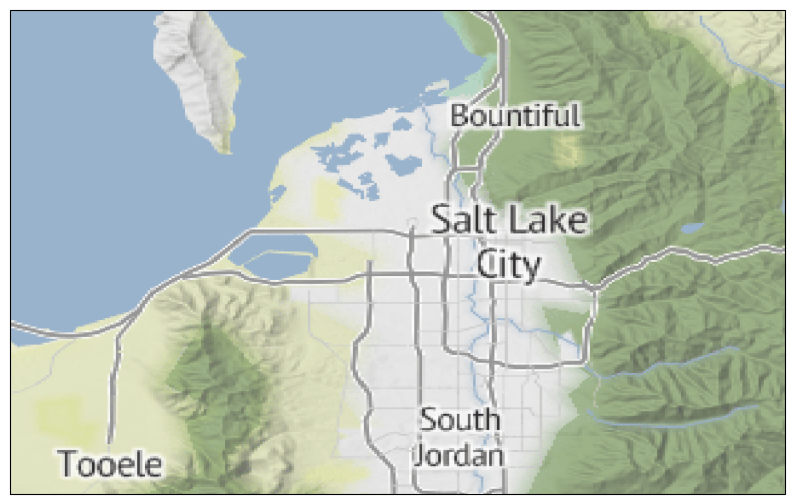

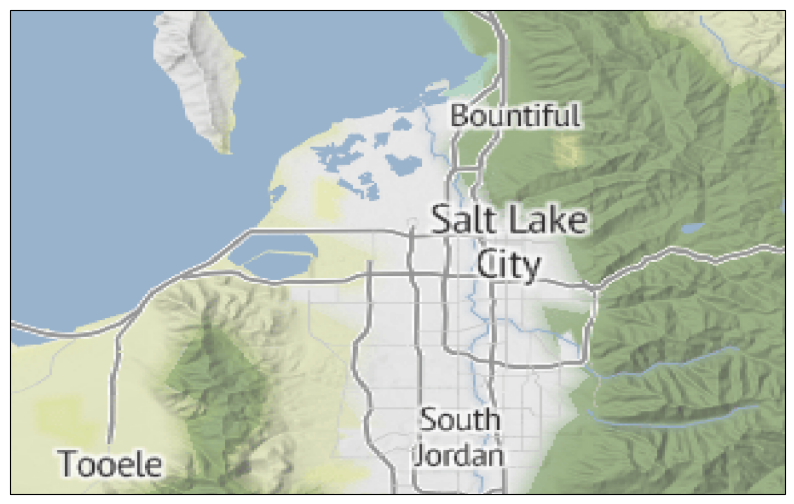

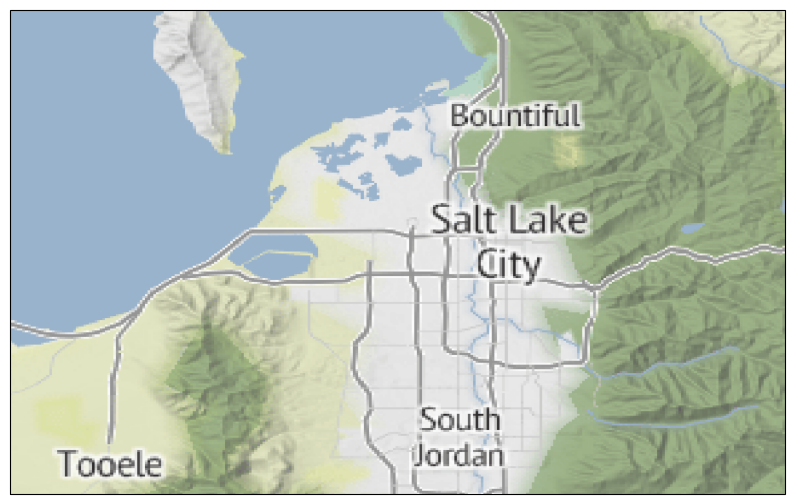

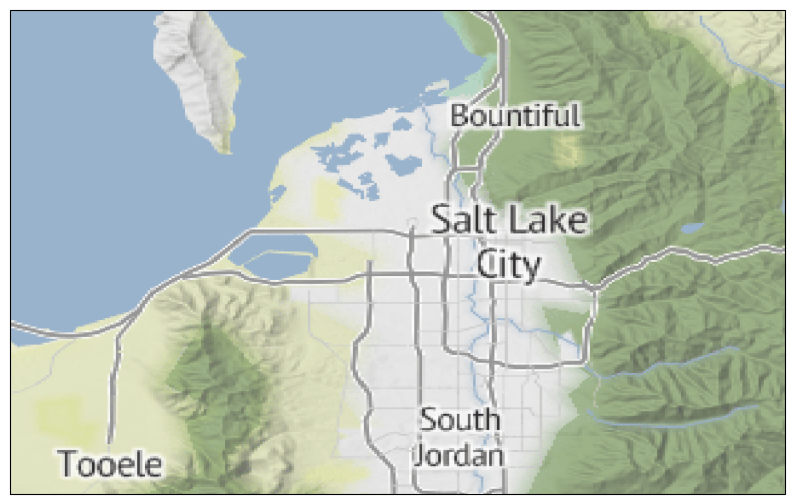

ValueError: could not broadcast input array from shape (512,512,3) into shape (766,766,3)

<Figure size 1000x800 with 1 Axes>

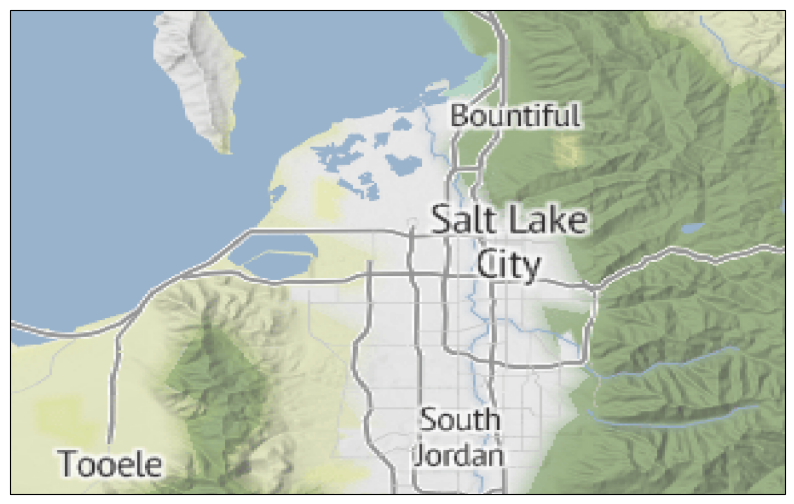

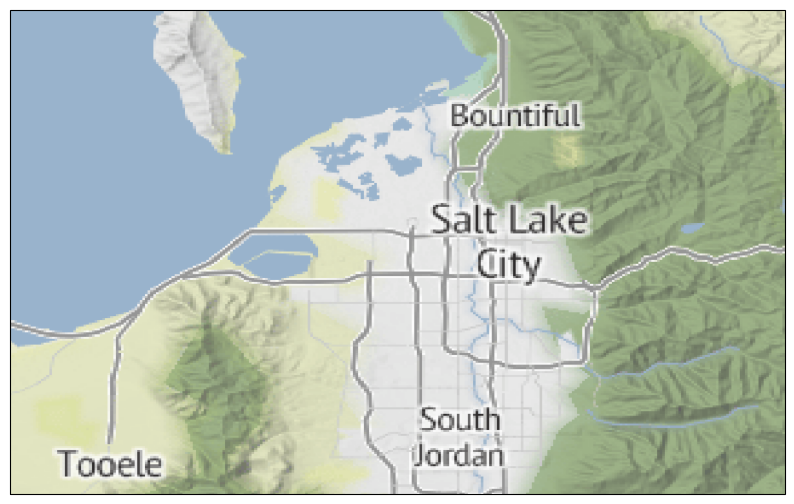

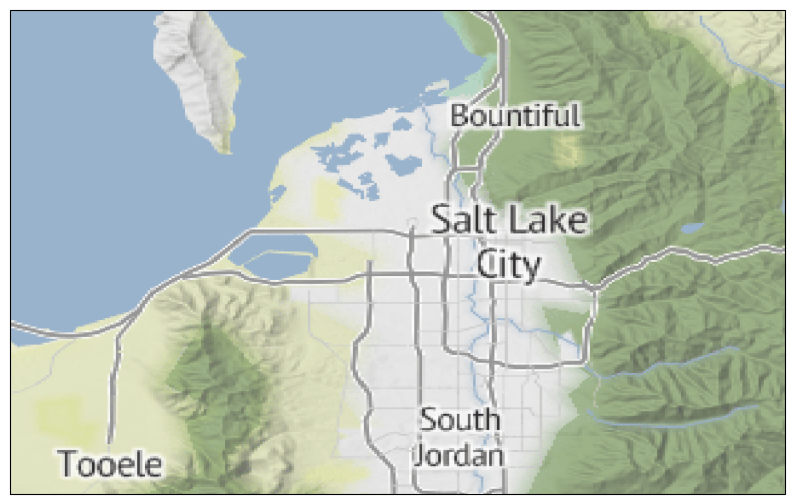

ValueError: could not broadcast input array from shape (512,512,3) into shape (766,766,3)

<Figure size 1000x800 with 1 Axes>

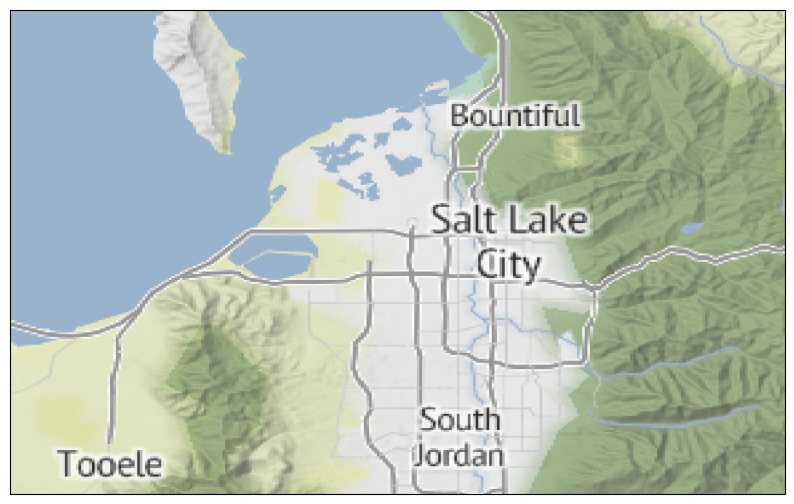

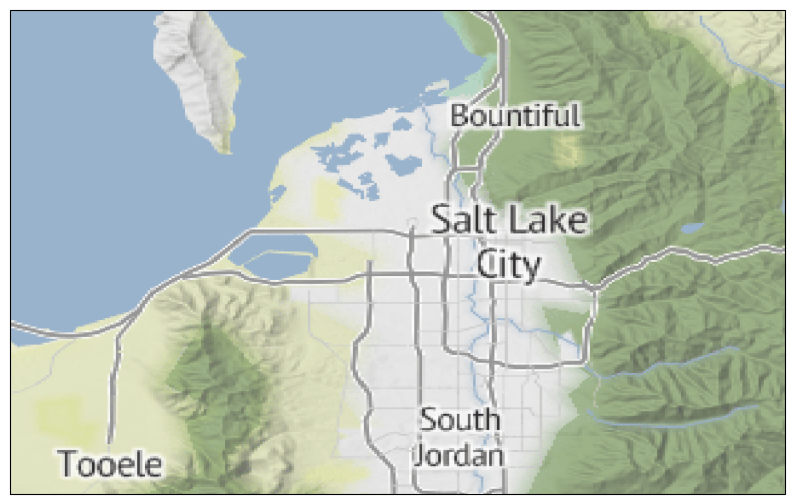

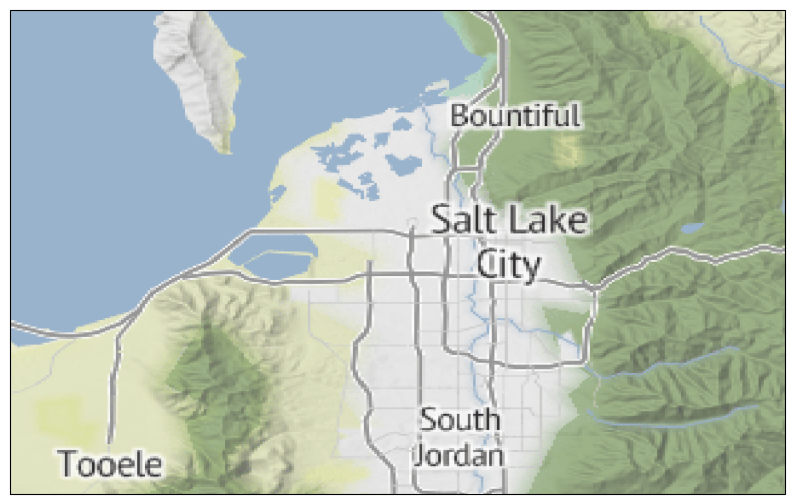

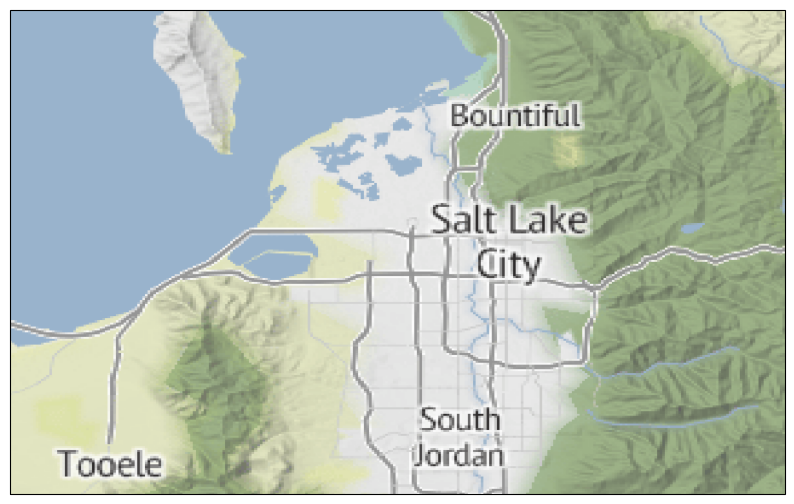

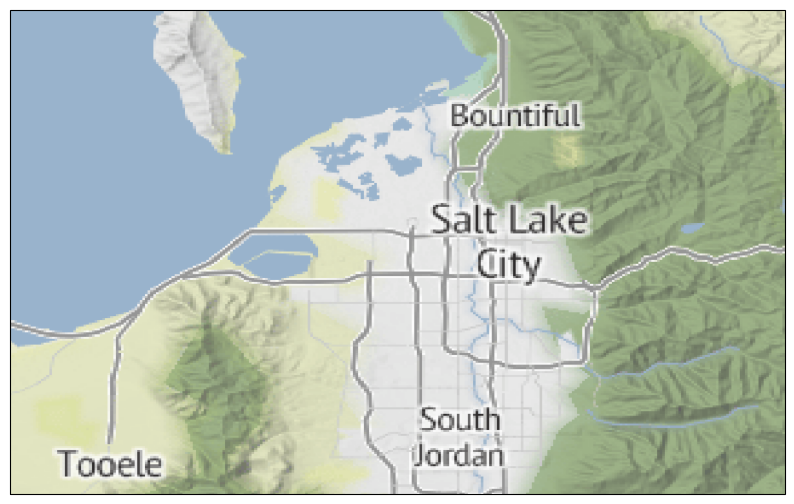

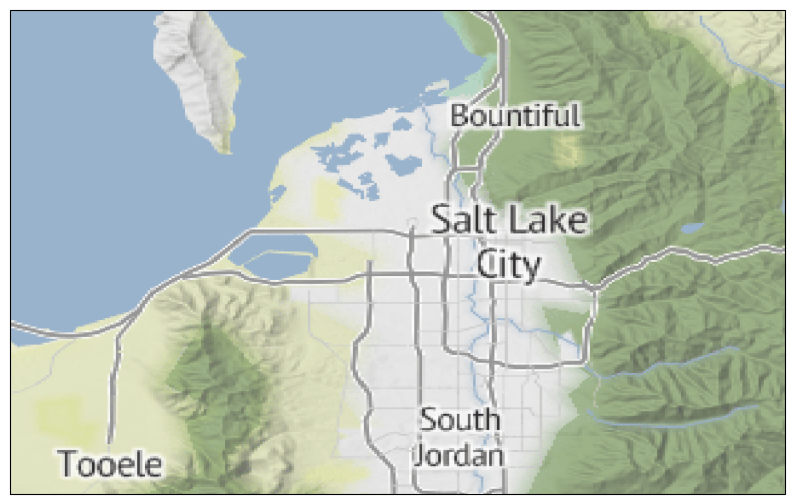

ValueError: could not broadcast input array from shape (512,512,3) into shape (766,766,3)

<Figure size 1000x800 with 1 Axes>

In [15]:

#day = '2022-08-23'
# for oco_type in days_with_data.keys():
#     for day in days_with_data[oco_type].keys():
        # print(day)
        # oco_filename = days_with_data[oco_type][day]['oco_filename']
        # xr_ds = xr.open_dataset(os.path.join(oco_data_folders[oco_type],oco_filename))
        # oco_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
        # oco_df = oco_df.loc[oco_df['xco2_quality_flag']==0]
        # oco_subdf = oco_df.loc[(oco_df['longitude']>=map_extent[0])&
        #                 (oco_df['longitude']<=map_extent[1])&
        #                 (oco_df['latitude']>=map_extent[2])&
        #                 (oco_df['latitude']<=map_extent[3])]
        # if len(oco_subdf)==0:
        #     print(f'No Data in Map Domain for {day}')
        #     continue
        # oco_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco_subdf['latitude'],oco_subdf['longitude'])
        # oco_subdf['inradius'] = oco_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
        # if len(oco_subdf.loc[oco_subdf['inradius']]) == 0:
        #     oco_inradius_start_dt = None
        #     oco_inradius_end_dt = None
        #     oco_inradius_mean_xco2 = np.nan
        #     oco_inradius_std_xco2 = np.nan
        #     oco_inradius_num_soundings = 0
        # else:
        #     oco_inradius_start_dt = pytz.timezone(tz).localize(min(oco_subdf.loc[oco_subdf['inradius']]['time']))
        #     oco_inradius_end_dt = pytz.timezone(tz).localize(max(oco_subdf.loc[oco_subdf['inradius']]['time']))
        #     oco_inradius_mean_xco2 = oco_subdf.loc[oco_subdf['inradius']]['xco2'].mean()
        #     oco_inradius_std_xco2 = oco_subdf.loc[oco_subdf['inradius']]['xco2'].std()
        #     oco_inradius_num_soundings = len(oco_subdf.loc[oco_subdf['inradius']])

        # oof_filename = days_with_data[oco_type][day]['oof_filename']
        # my_oof_manager = ac.oof_manager(oof_data_folder,tz)
        # oof_df = my_oof_manager.df_from_oof(os.path.join(oof_data_folder,oof_filename),fullformat = True,filter_flag_0=True)
        # if oco_inradius_start_dt is None:
        #     oof_df['overpass_window'] = False
        #     intime_oof_num = 0
        #     intime_oof_mean_xco2 = np.nan
        #     intime_oof_std_xco2 = np.nan
        # else:
        #     oof_df['overpass_window'] = (oof_df.index>=oco_inradius_start_dt-oof_surround_time)&(oof_df.index<=oco_inradius_end_dt+oof_surround_time)
        #     intime_oof_num = len(oof_df.loc[oof_df['overpass_window']])
        #     intime_oof_mean_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].mean()
        #     intime_oof_std_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].std()

        # step = 0.02
        # to_bin = lambda x: np.floor(x/step)*step
        # oco_subdf['latbin'] = to_bin(oco_subdf['latitude'])
        # oco_subdf['lonbin'] = to_bin(oco_subdf['longitude'])
        # plot_xr = oco_subdf.groupby(['latbin','lonbin']).mean(numeric_only=True).to_xarray()

        #labsize = 12
        proj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(10,8))
        ax = plt.axes(projection = proj)
        ax.set_extent(map_extent,crs=proj)
        request = cimgt.Stamen(style='terrain')
        scale = 9.0 # empirical solve for scale based on zoom
        ax.add_image(request,int(scale))
        
        # map = plot_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)

        # ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'red',marker = 'X',s = 100)

        # cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
        # geom = sgeom.Polygon(cp)
        # ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

        # text = f"IN RADIUS, IN RANGE\n\n\
        # OCO Soundings = {oco_inradius_num_soundings}\n\
        # OCO XCO2_mean = {oco_inradius_mean_xco2:.{2}f}ppm\n\
        # OCO XCO2_std = {oco_inradius_std_xco2:.{2}f}ppm\n\n\
        # EM27 Obs = {intime_oof_num}\n\
        # EM27 XCO2_mean = {intime_oof_mean_xco2:.{2}f}\n\
        # EM27 XCO2_std = {intime_oof_std_xco2:.{2}f}ppm\
        # "
        # at = AnchoredText(text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=10))
        # ax.add_artist(at)

        # axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
        # axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'grey',zorder=3,s=1)
        # if oco_inradius_start_dt is not None:
        #     window_base = (min(oof_df.loc[oof_df['overpass_window']].index),min(oof_df['xco2(ppm)']))
        #     width = max(oof_df.loc[oof_df['overpass_window']].index)-min(oof_df.loc[oof_df['overpass_window']].index)
        #     height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
        #     rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5)
        #     axins.add_patch(rect)
        # axins.tick_params(labelsize = labsize)
        # axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-3)
        # #axins.set_ylim([415,425])
        # axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = tz))
        # axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
        # plt.gcf().autofmt_xdate()
        # ax.set_title(oco_type)
        # plt.colorbar(map,fraction=0.03,label ='XCO2 (ppm)')
        plt.show()
        plt.pause(1)
        plt.close()


2022-07-06


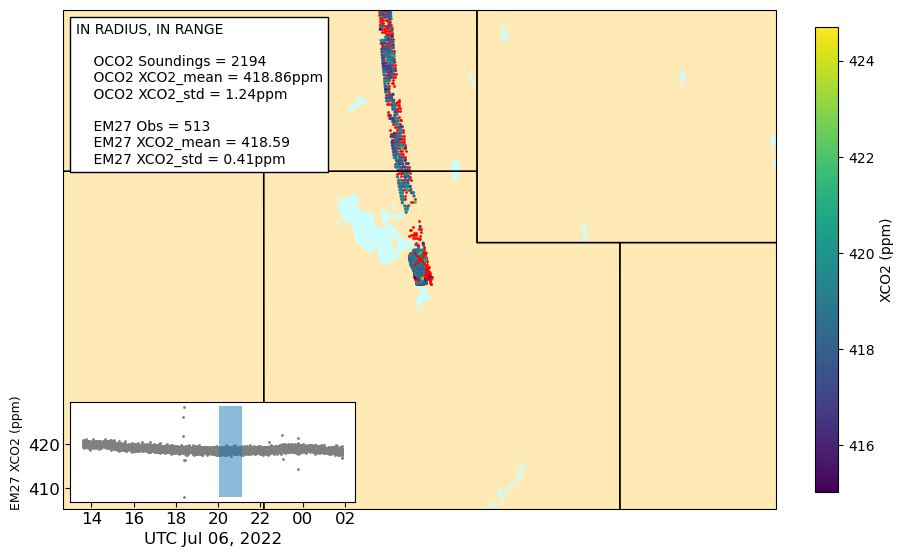

2022-07-29


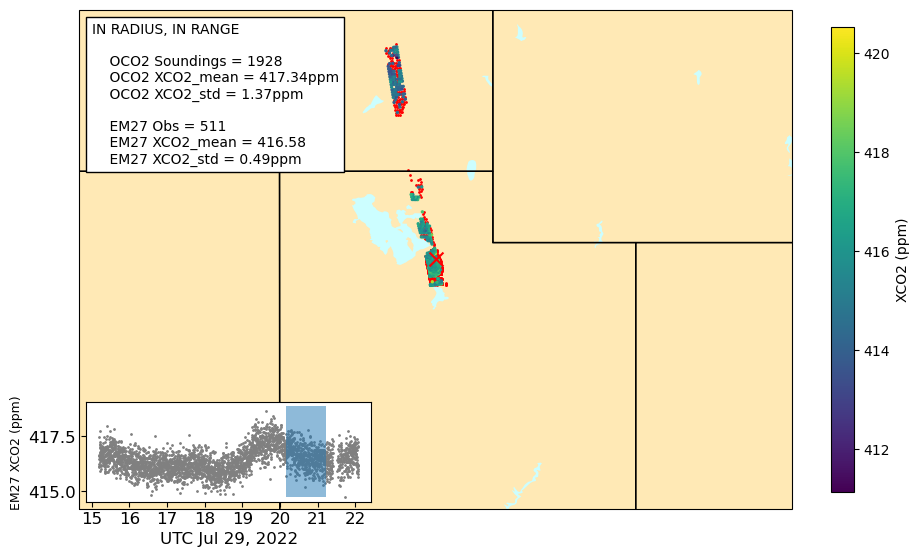

2022-07-31


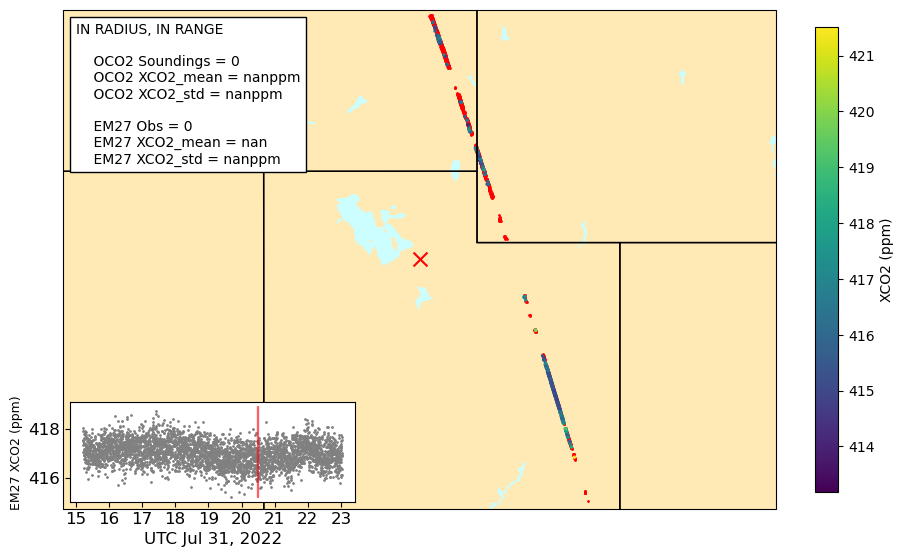

2022-08-16


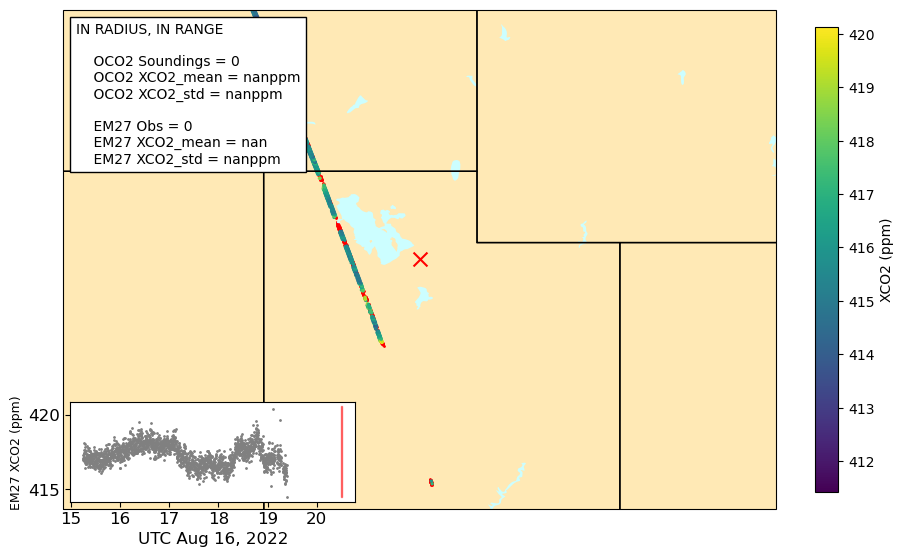

2022-08-23


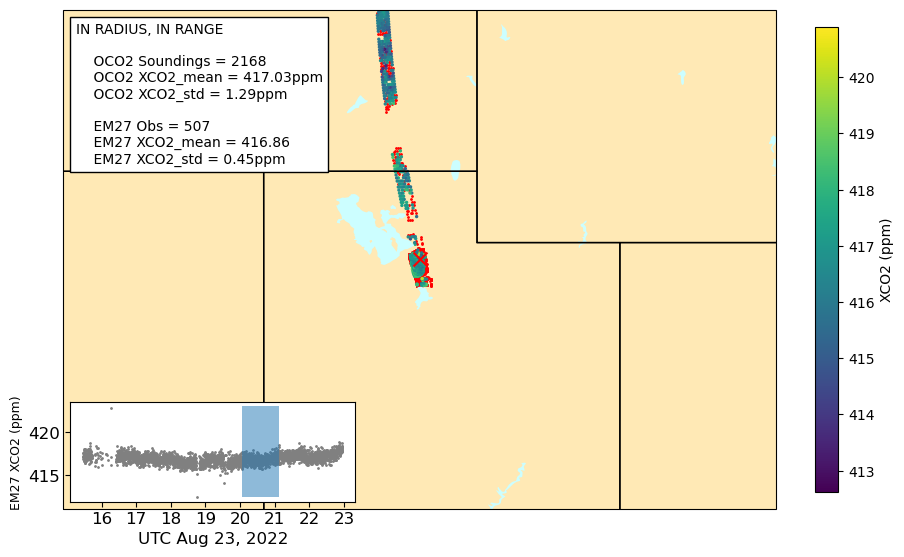

2022-09-01


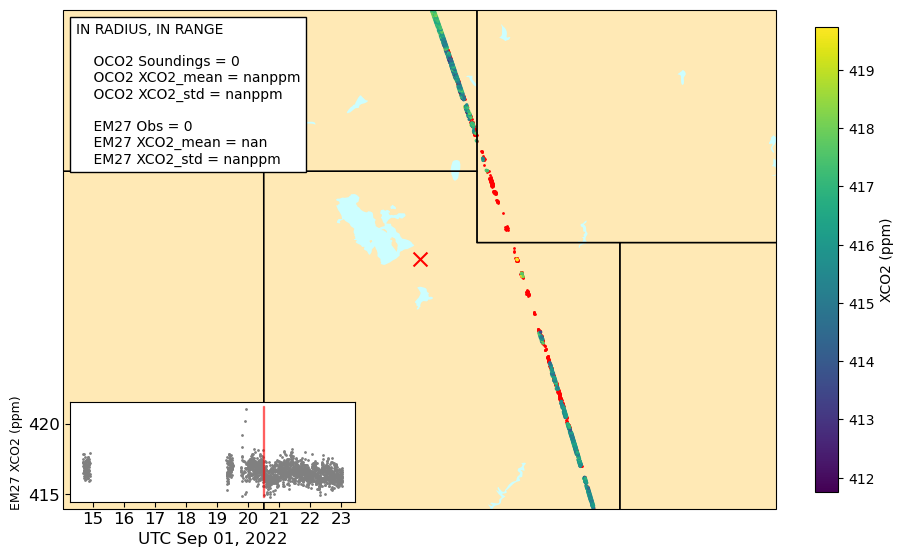

2022-09-08


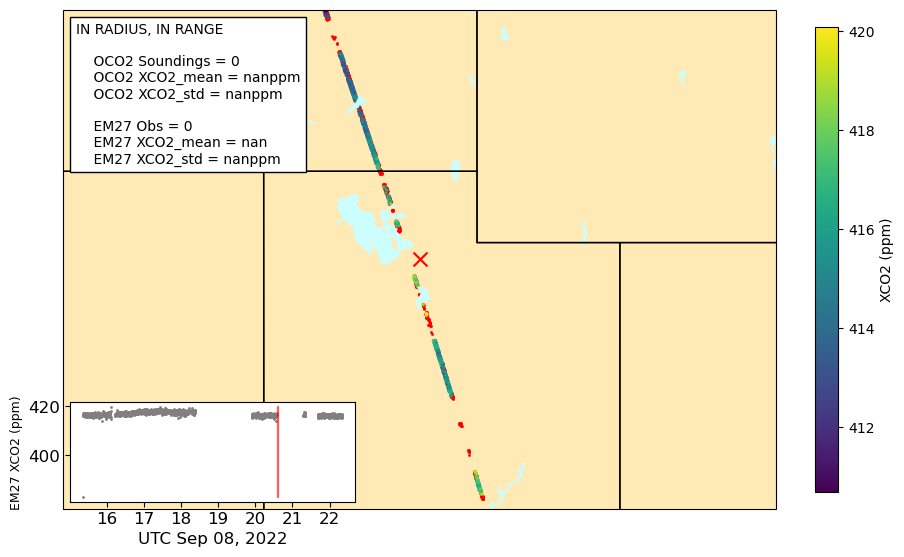

2022-10-03


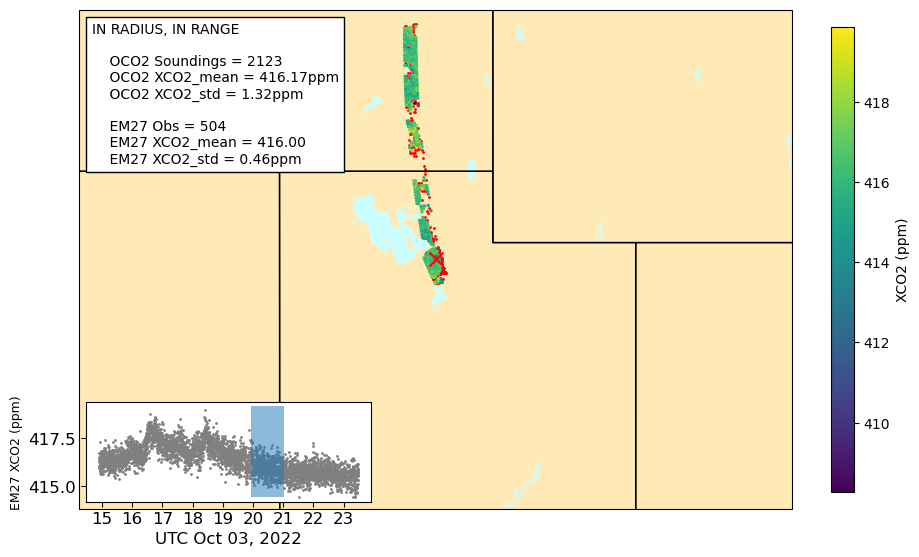

2022-10-10


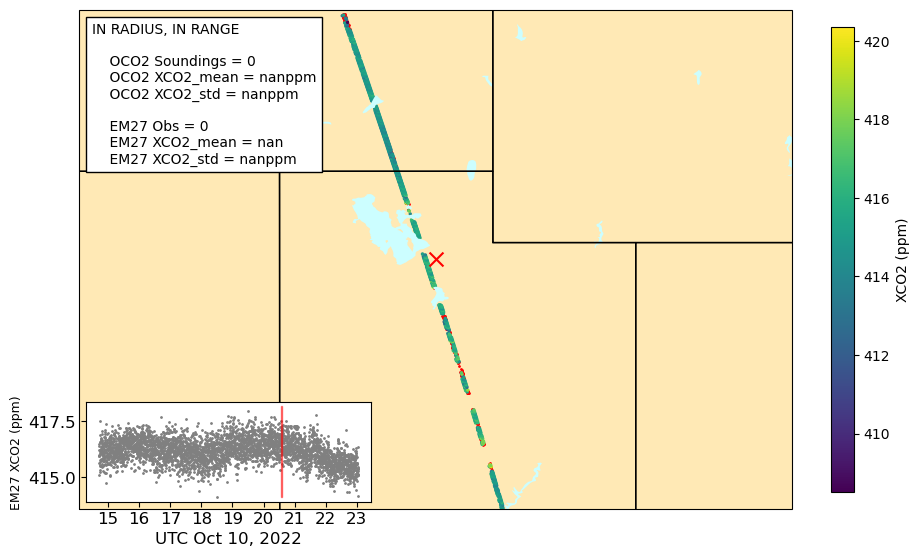

2022-11-04


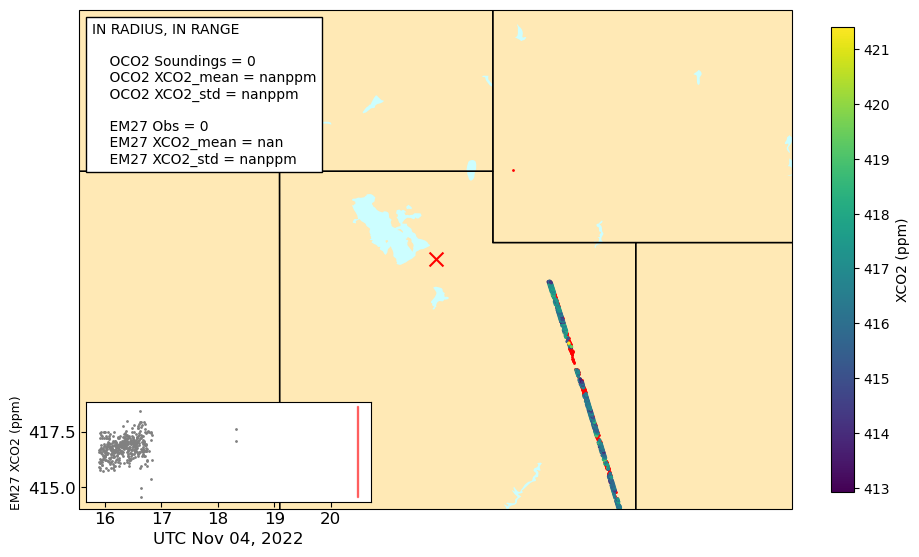

2022-11-11


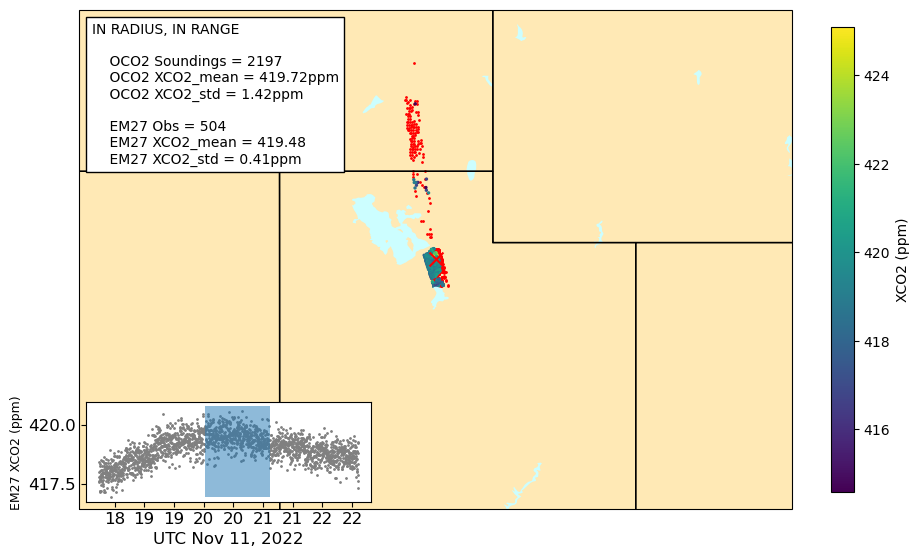

2023-01-23


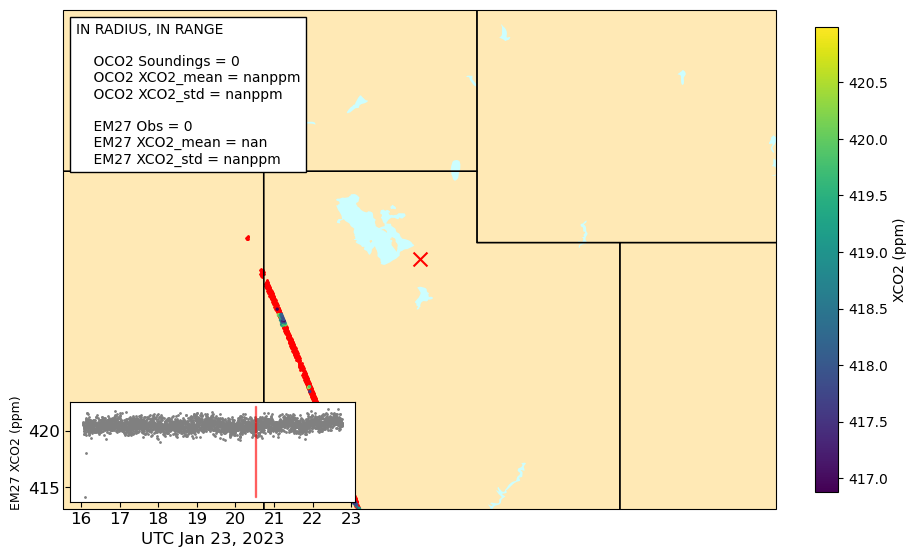

2023-01-30


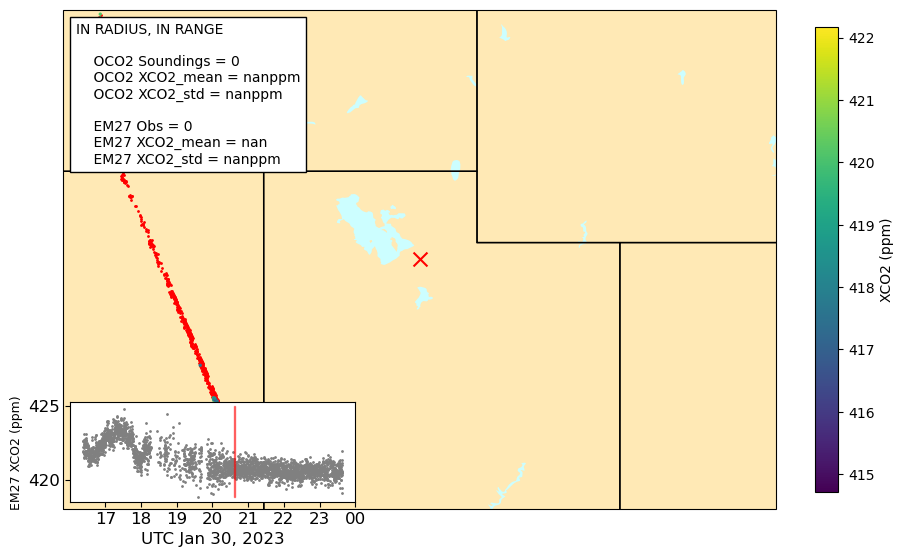

2023-02-08


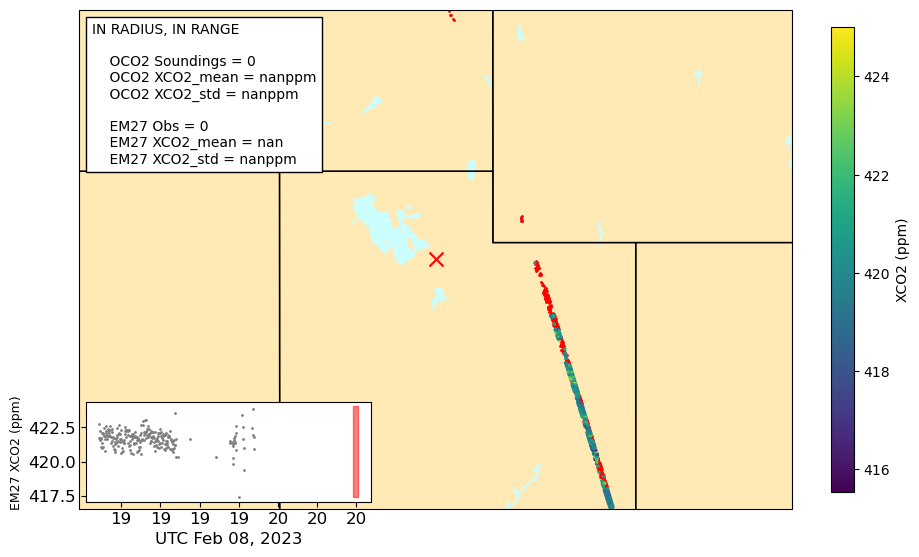

2023-02-24


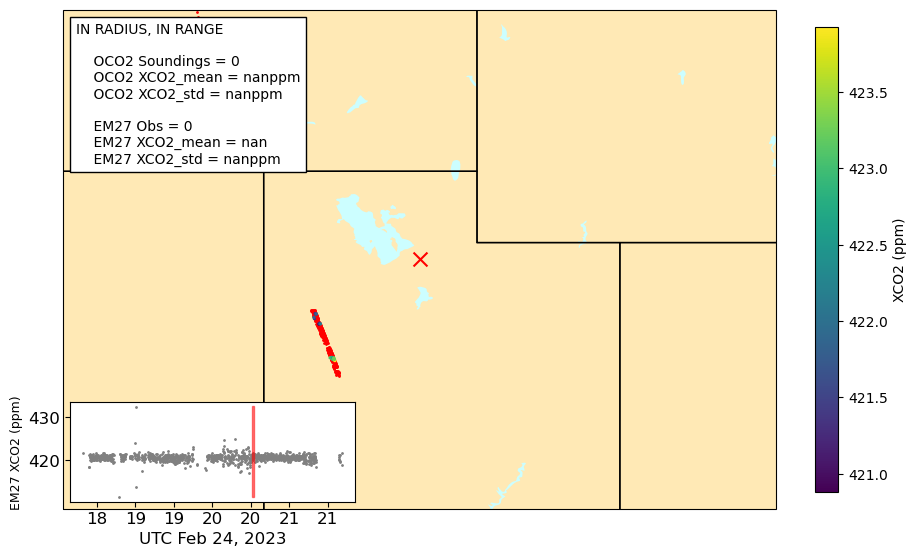

2023-03-19


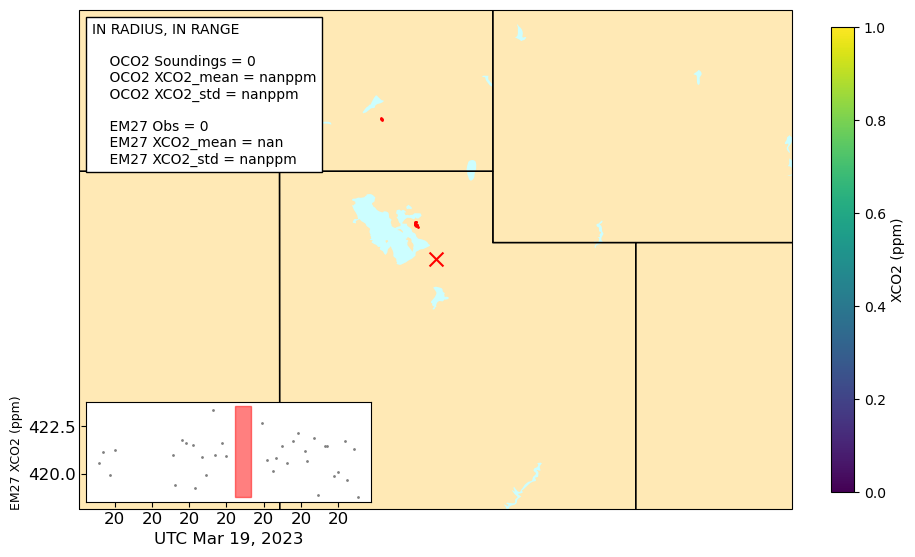

2023-03-28


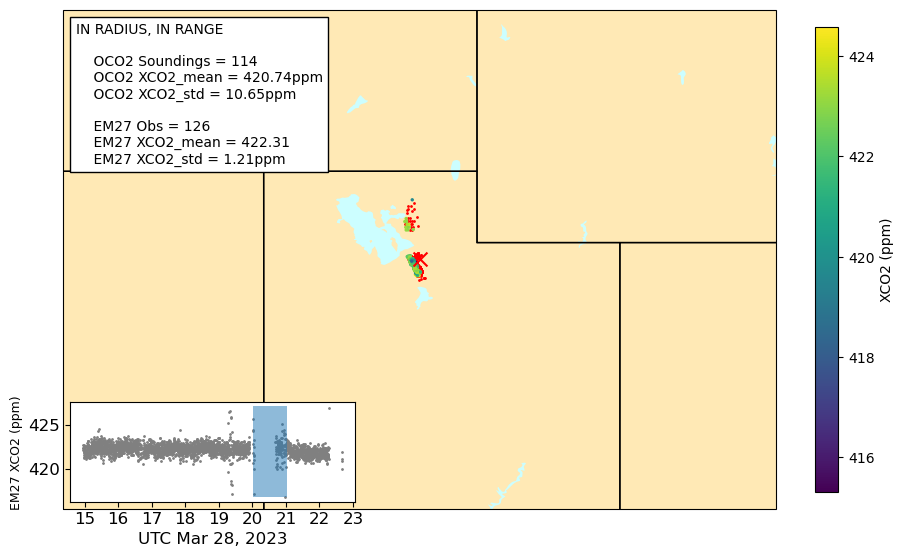

2023-04-11


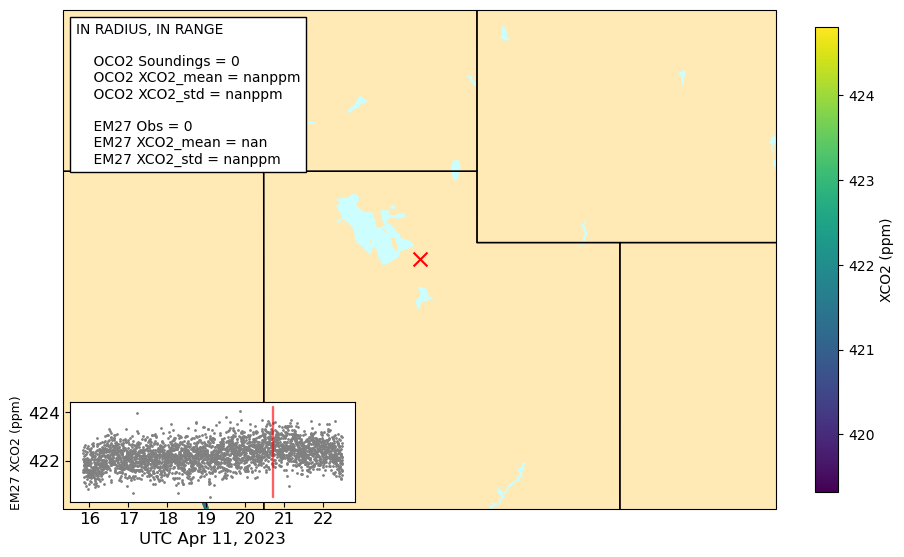

2023-04-20


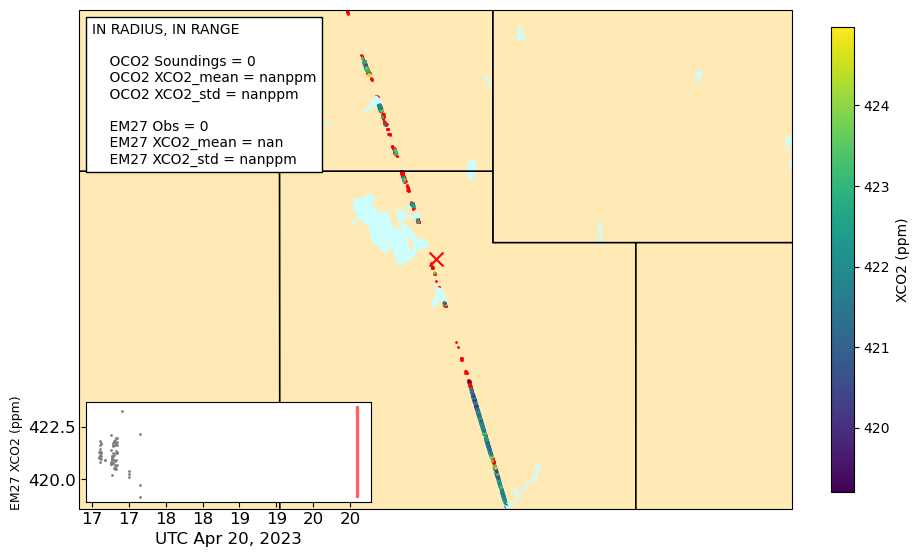

2023-04-27


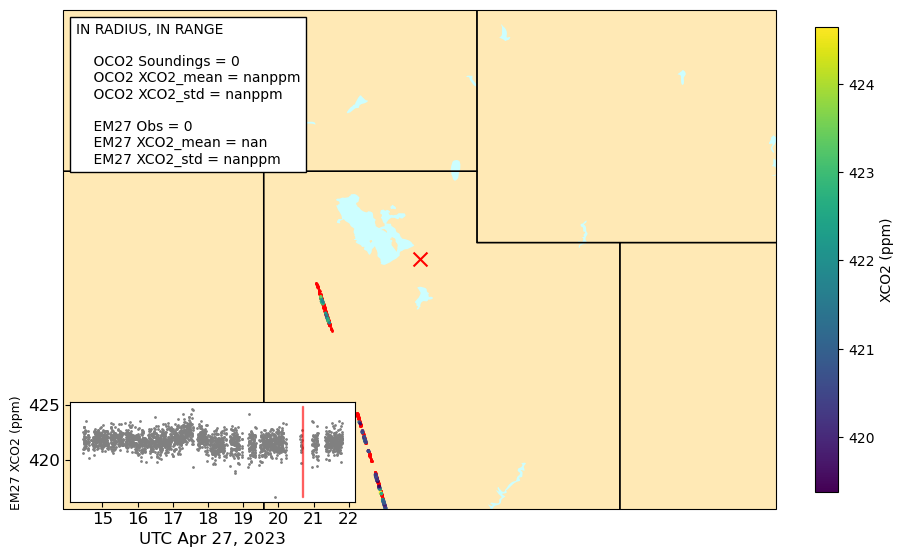

2023-04-29


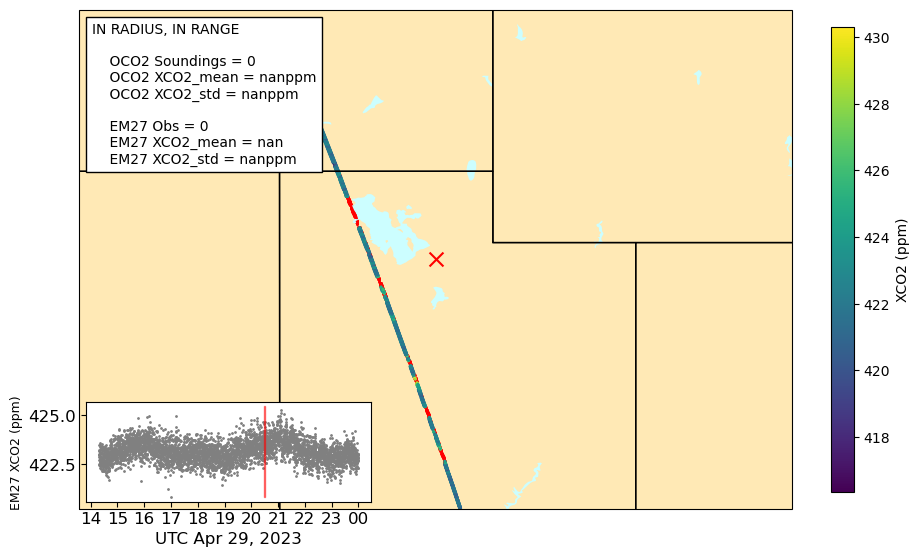

2023-05-15


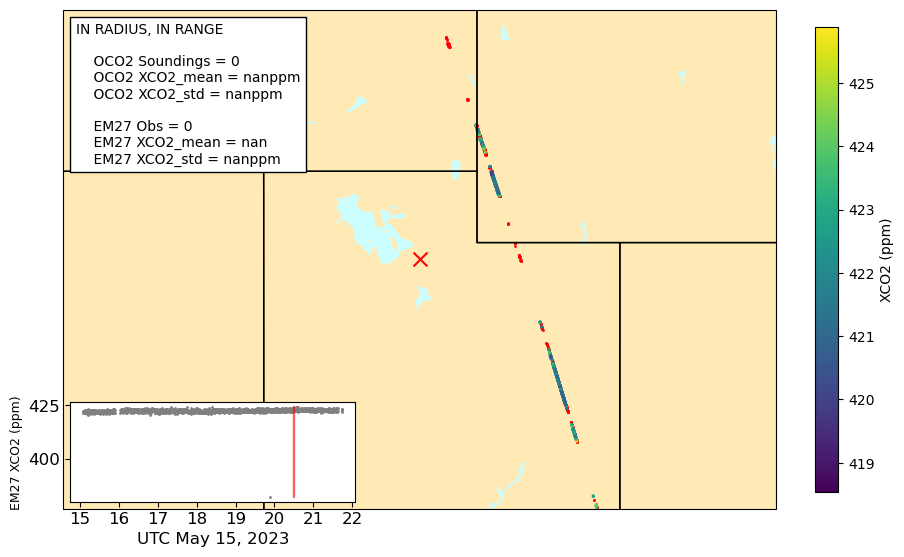

2023-05-22


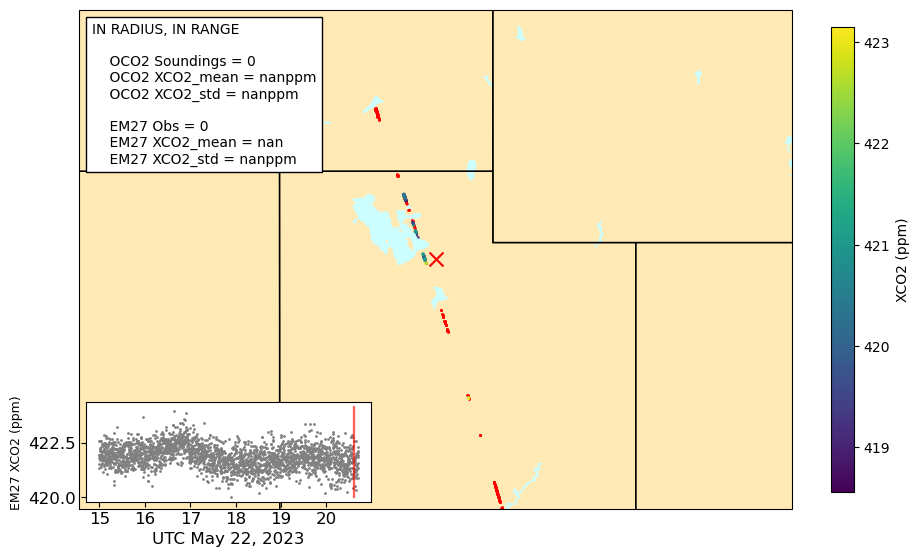

2023-05-31


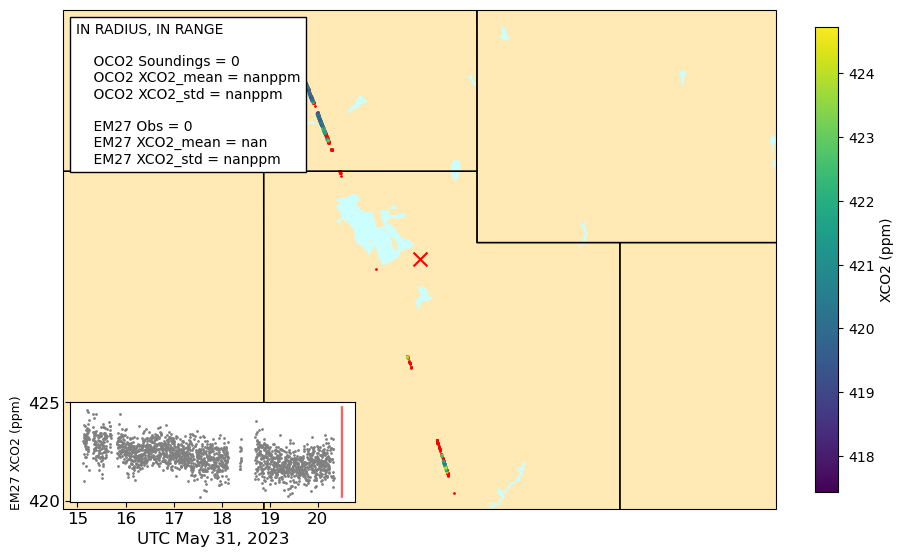

2023-06-16


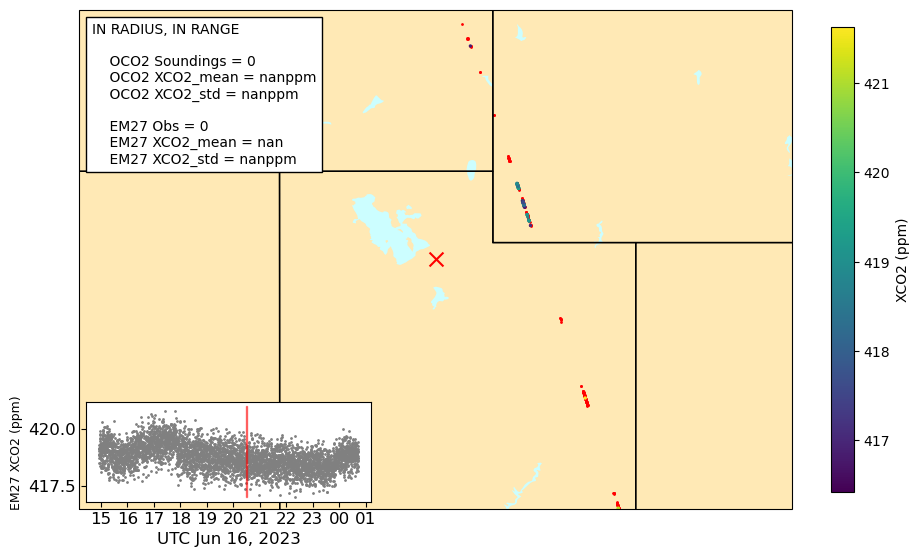

2023-06-23


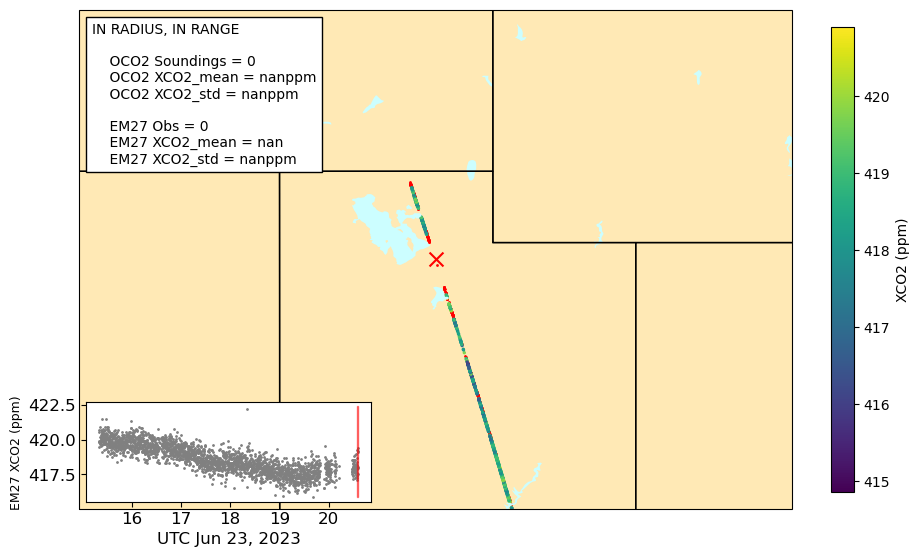

2023-07-09


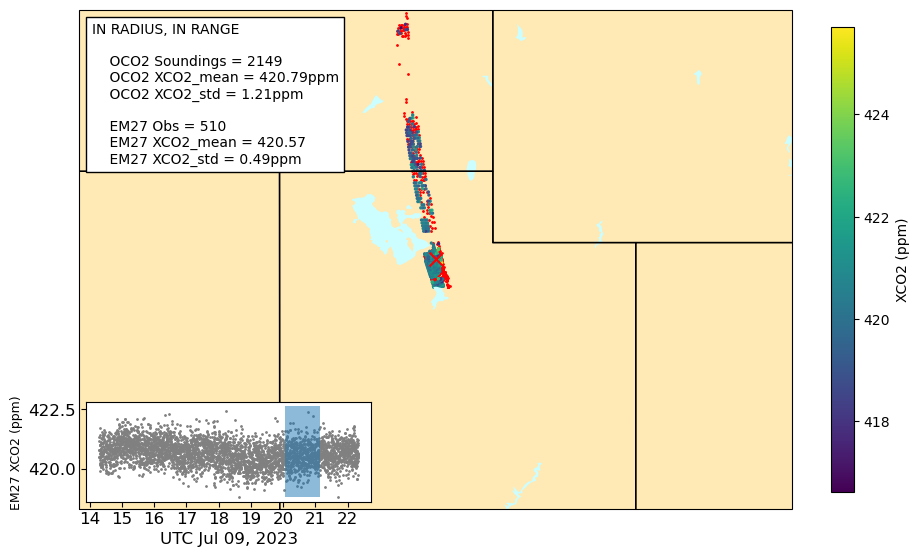

2023-07-18


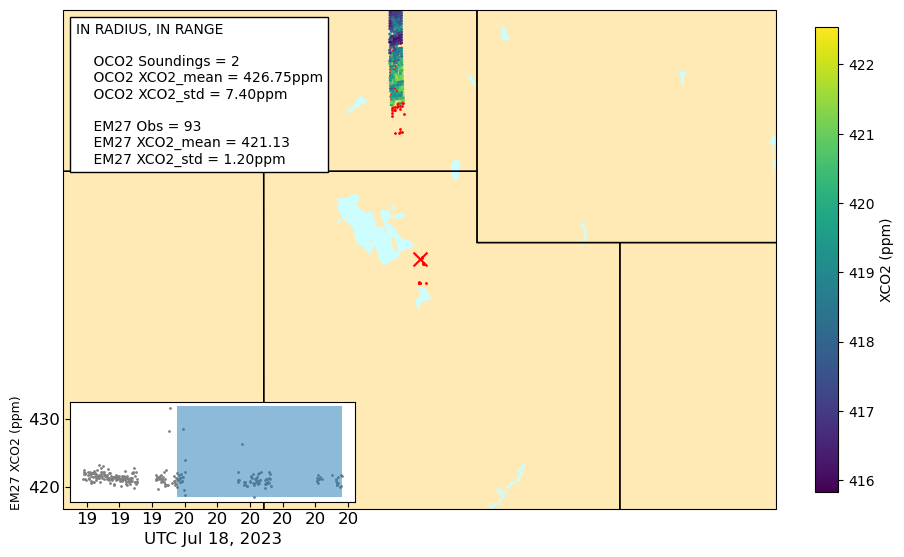

2023-07-23


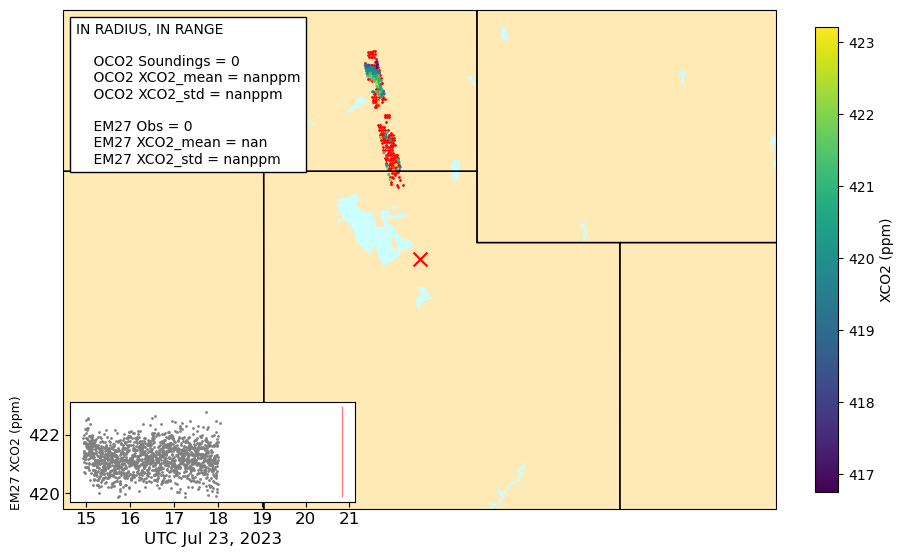

2023-07-25


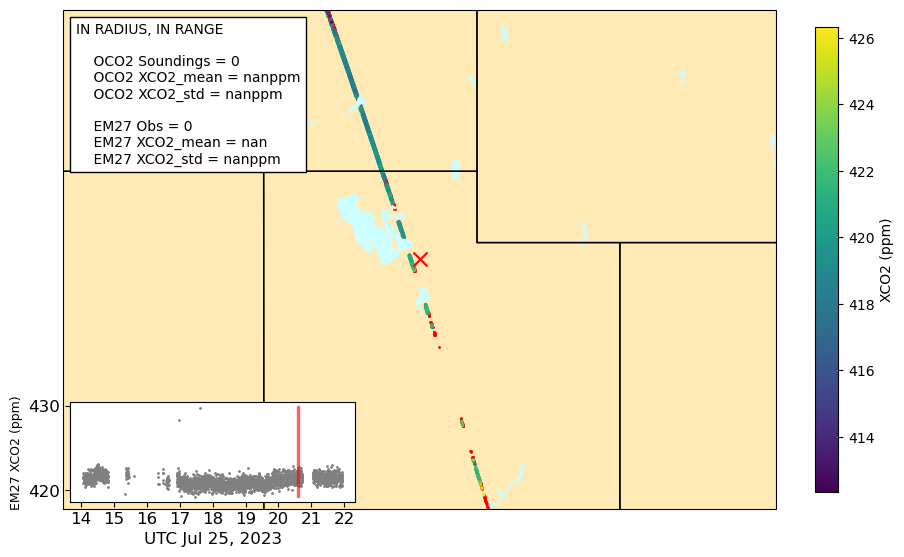

2023-07-27


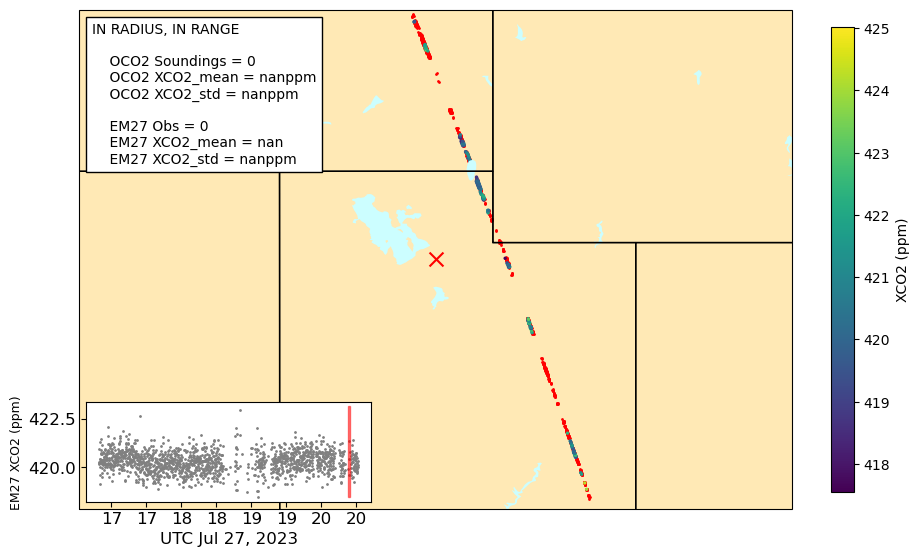

In [38]:
deg_offset = 5
map_extent=[inst_loc['lon']-deg_offset,inst_loc['lon']+deg_offset,inst_loc['lat']-deg_offset*0.7,inst_loc['lat']+deg_offset*0.7]

#day = '2022-08-23'
for day in days_with_data.keys():
    print(day)
    oco2_filename = days_with_data[day]['oco2_filename']
    tz = 'UTC'
    xr_ds = xr.open_dataset(os.path.join(oco2_data_folder,oco2_filename))

    oco2_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
    #oco2_df = oco2_df.loc[oco2_df['xco2_quality_flag']==0]
    oco2_subdf = oco2_df.loc[(oco2_df['longitude']>=map_extent[0])&
                    (oco2_df['longitude']<=map_extent[1])&
                    (oco2_df['latitude']>=map_extent[2])&
                    (oco2_df['latitude']<=map_extent[3])]
    if len(oco2_subdf)==0:
        print(f'No Data in Map Domain for {day}')
        continue
    oco2_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco2_subdf['latitude'],oco2_subdf['longitude'])
    oco2_subdf['inradius'] = oco2_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
    oco2_subdf['dt'] = pd.to_datetime(oco2_subdf['time']).dt.tz_localize(tz)
    oco2_subdf = oco2_subdf.set_index('dt')
    if len(oco2_subdf.loc[oco2_subdf['inradius']]) == 0:
        oco2_inradius_start_dt = None
        oco2_inradius_end_dt = None
        oco2_inradius_mean_xco2 = np.nan
        oco2_inradius_std_xco2 = np.nan
        oco2_inradius_num_soundings = 0
    else:
        oco2_inradius_start_dt = pytz.timezone(tz).localize(min(oco2_subdf.loc[oco2_subdf['inradius']]['time']))
        oco2_inradius_end_dt = pytz.timezone(tz).localize(max(oco2_subdf.loc[oco2_subdf['inradius']]['time']))
        oco2_inradius_mean_xco2 = oco2_subdf.loc[oco2_subdf['inradius']]['xco2'].mean()
        oco2_inradius_std_xco2 = oco2_subdf.loc[oco2_subdf['inradius']]['xco2'].std()
        oco2_inradius_num_soundings = len(oco2_subdf.loc[oco2_subdf['inradius']])

    oof_filename = days_with_data[day]['oof_filename']
    my_oof_manager = ac.oof_manager(oof_data_folder,tz)
    oof_df = my_oof_manager.df_from_oof(os.path.join(oof_data_folder,oof_filename),fullformat = True,filter_flag_0=True)
    if oco2_inradius_start_dt is None:
        oof_df['overpass_window'] = False
        intime_oof_num = 0
        intime_oof_mean_xco2 = np.nan
        intime_oof_std_xco2 = np.nan
    else:
        oof_df['overpass_window'] = (oof_df.index>=oco2_inradius_start_dt-oof_surround_time)&(oof_df.index<=oco2_inradius_end_dt+oof_surround_time)
        intime_oof_num = len(oof_df.loc[oof_df['overpass_window']])
        intime_oof_mean_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].mean()
        intime_oof_std_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].std()

    # step = 0.02
    # to_bin = lambda x: np.floor(x/step)*step
    # oco2_subdf['latbin'] = to_bin(oco2_subdf['latitude'])
    # oco2_subdf['lonbin'] = to_bin(oco2_subdf['longitude'])
    # plot_xr = oco2_subdf.groupby(['latbin','lonbin']).mean(numeric_only=True).to_xarray()

    labsize = 12
    zoom = 1
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection = proj)
    ax.set_extent(map_extent,crs=proj)
    # request = cimgt.Stamen(style='terrain')
    # scale = 7#np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    # ax.add_image(request,int(scale))
    ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
    ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
    ax.add_feature(cfeature.STATES)
    #map = plot_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
    good_oco2 = oco2_subdf.loc[oco2_subdf['xco2_quality_flag']==0]
    bad_oco2 = oco2_subdf.loc[oco2_subdf['xco2_quality_flag']!=0]
    map = ax.scatter(bad_oco2['longitude'],bad_oco2['latitude'],color = 'red',s=1)

    map = ax.scatter(good_oco2['longitude'],good_oco2['latitude'],c=good_oco2['xco2'],s=2)

    ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'red',marker = 'x',s = 100)

    #cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
    #geom = sgeom.Polygon(cp)
    #ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

    text = f"IN RADIUS, IN RANGE\n\n\
    OCO2 Soundings = {oco2_inradius_num_soundings}\n\
    OCO2 XCO2_mean = {oco2_inradius_mean_xco2:.{2}f}ppm\n\
    OCO2 XCO2_std = {oco2_inradius_std_xco2:.{2}f}ppm\n\n\
    EM27 Obs = {intime_oof_num}\n\
    EM27 XCO2_mean = {intime_oof_mean_xco2:.{2}f}\n\
    EM27 XCO2_std = {intime_oof_std_xco2:.{2}f}ppm\
    "
    at = AnchoredText(text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=10))
    ax.add_artist(at)

    axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
    axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'grey',zorder=3,s=1)
    if oco2_inradius_start_dt is not None:
        window_base = (min(oof_df.loc[oof_df['overpass_window']].index),min(oof_df['xco2(ppm)']))
        width = max(oof_df.loc[oof_df['overpass_window']].index)-min(oof_df.loc[oof_df['overpass_window']].index)
        height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
        rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5)
        axins.add_patch(rect)
    else:
        window_base = (min(oco2_subdf.index),min(oof_df['xco2(ppm)']))
        width = max(oco2_subdf.index)-min(oco2_subdf.index)
        height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
        rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5,color='red')
        axins.add_patch(rect)
    axins.tick_params(labelsize = labsize)
    axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-3)
    #axins.set_ylim([415,425])
    axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = tz))
    axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
    plt.gcf().autofmt_xdate()

    plt.colorbar(map,fraction=0.03,label ='XCO2 (ppm)')
    plt.show()
    

# Jonathan

In [240]:
OCO2SAMS = glob.glob('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/OCO/OCO2/from_elaine/*.nc4')
OCO2SAMS.sort()

baselat = 40.76
baselon = -111.85
latrange = .2
lonrange = .3

latlow = baselat - latrange
lathigh = baselat + latrange
lonlow = baselon - lonrange
lonhigh = baselon + lonrange

datelist = []
co2list = []
em27list = []
em27error = []
ocoerror=[]
for SAM in OCO2SAMS:
    d = Dataset(SAM,'r')
    co2 = np.squeeze(d.variables['xco2'][:])
    #print(co2)
    co2qf = np.squeeze(d.variables['xco2_quality_flag'][:])
    #print(co2qf)
    #print(d.variables['vertex_longitude'][:,0])
    lon = np.squeeze(d.variables['vertex_longitude'][:,0])
    lat = np.squeeze(d.variables['vertex_latitude'][:,0])
    sec = np.squeeze(d.variables['time'][:])
    #print(co2m)
    co2m = np.ma.array(co2,mask=((co2qf!=1) | (lat<latlow) | (lat>lathigh) | (lon<lonlow) | (lon>lonhigh)))
    if len(co2m.compressed()) == 0:
        continue
    secm = np.ma.array(sec,mask=((co2qf!=1) | (lat<latlow) | (lat>lathigh) | (lon<lonlow) | (lon>lonhigh)))
    #print(secm)
    #print(secm.compressed())
    sec = np.mean(secm.compressed())
    #print(sec)
    date = dt.datetime(1970,1,1) + dt.timedelta(seconds=sec)
    #print(date)#print(np.mean(co2m))
    #sys.exit()
    print('{}: {} soundings, {} useable.  Mean CO2 of {}'.format(
        date.strftime('%Y%m%d'),len(co2),co2m.count(),np.mean(co2m)))
    if co2m.count() > 10.:

        datestr = date.strftime('%Y%m%d')
        fil = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/ha{0}.vav.ada.aia.oof'.format(datestr)
        if not(osp.exists(fil)):
           print('No EM27 data for {}'.format(datestr))
           continue
        temp = open(fil,'r')
        hnum = int(temp.readline().split()[0])-51
        print( hnum)
        temp.close()
        oof = pd.read_csv(fil,header=hnum,sep=' ',
                   skipinitialspace=True,parse_dates=[[2,3,4]],
                   date_parser=lambda *columns: dt.datetime(
                   int(columns[0][:-1]),1,1)+dt.timedelta(
                   days=int(columns[1][:-1])-1,
                   seconds=float(columns[2])*3600.))
        oof.rename(columns=lambda x: x.replace('(', '_'), inplace=True)
        oof.rename(columns=lambda x: x.replace(')', ''), inplace=True)

        oof.index = oof.year_day_hour
        oof = oof[oof.index > date-dt.timedelta(seconds=3600)]
        oof = oof[oof.index < date+dt.timedelta(seconds=3600)]
        quantiles = oof['xco2_ppm'].quantile([.25,.5,.75])
        emhigherr=quantiles[.75]-quantiles[.50]
        emlowerr=quantiles[.50]-quantiles[.25]
        #print(quantiles)
        #print(np.shape(quantiles))
        #print(quantiles[0.25])
        #sys.exit()
        datelist.append(date)
        mco2m = np.percentile(co2m.compressed(),50)
        ocohigh=np.percentile(co2m.compressed(),75)-mco2m
        ocolow=mco2m-np.percentile(co2m.compressed(),25)
        co2list.append(np.mean(co2m))
        em27list.append(quantiles[.50])
        em27error.append([emlowerr,emhigherr])
        ocoerror.append([ocolow,ocohigh])

20220510: 147180 soundings, 3141 useable.  Mean CO2 of 420.7976361031519
No EM27 data for 20220510
20220512: 152218 soundings, 1590 useable.  Mean CO2 of 419.2556603773585
No EM27 data for 20220512
20220629: 154233 soundings, 271 useable.  Mean CO2 of 420.643161900369
No EM27 data for 20220629
20220706: 139254 soundings, 1643 useable.  Mean CO2 of 420.4384129640901
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',
/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20220729: 174838 soundings, 2337 useable.  Mean CO2 of 417.60849914420197
251
20220823: 188610 soundings, 1873 useable.  Mean CO2 of 418.1490589962627
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',
/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20221003: 168011 soundings, 1451 useable.  Mean CO2 of 417.57972949689866
251
20221111: 149377 soundings, 1506 useable.  Mean CO2 of 421.1596945551129
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20230328: 167503 soundings, 1024 useable.  Mean CO2 of 417.2680969238281
261


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


In [243]:
datelist

[datetime.datetime(2022, 7, 6, 20, 35, 17, 950531),
 datetime.datetime(2022, 7, 29, 20, 41, 13, 626628),
 datetime.datetime(2022, 8, 23, 20, 35, 2, 211831),
 datetime.datetime(2022, 10, 3, 20, 28, 48, 493719),
 datetime.datetime(2022, 11, 11, 20, 34, 21, 960279),
 datetime.datetime(2023, 3, 28, 20, 30, 12, 238141)]

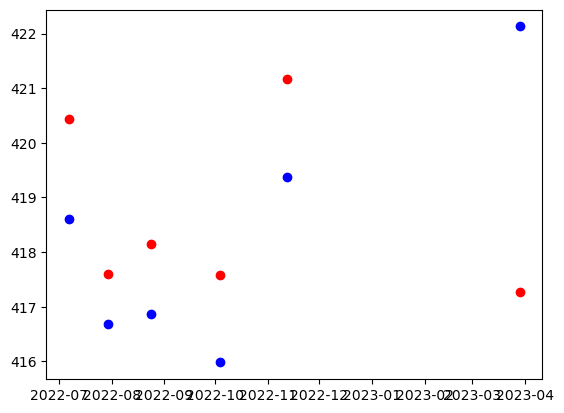

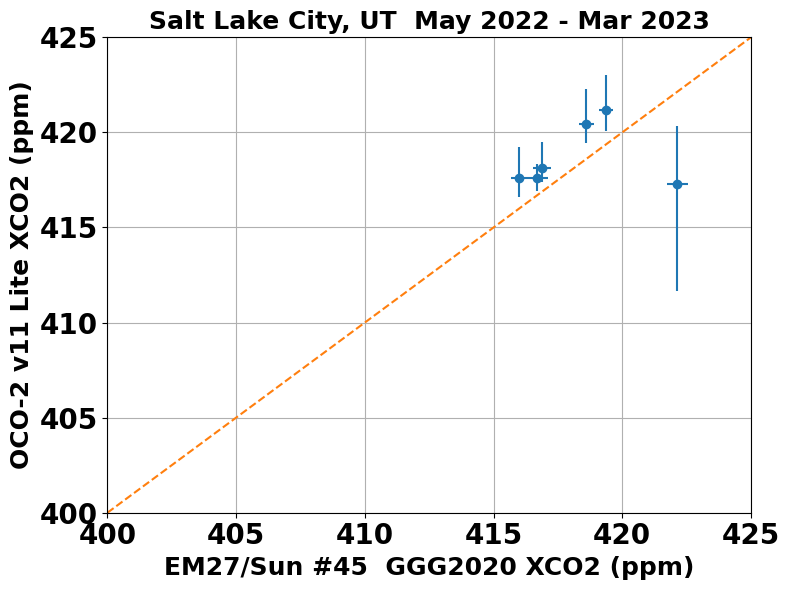

In [242]:
#for i in datelist:
#    print(i)
plt.plot(datelist,co2list,'ro')
plt.plot(datelist,em27list,'bo')
fig= plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
plt.errorbar(em27list,co2list,xerr=np.transpose(em27error),
        yerr=np.transpose(ocoerror),fmt='o')
plt.plot(range(400,450),range(400,450),'--')
plt.xlim([400,425])
plt.ylim([400,425])
plt.grid()
plt.xlabel('EM27/Sun #45  GGG2020 XCO2 (ppm)',fontsize=18,fontweight='bold')
plt.ylabel('OCO-2 v11 Lite XCO2 (ppm)',fontsize=18,fontweight='bold')
plt.title('Salt Lake City, UT  May 2022 - Mar 2023',fontsize=18,fontweight='bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(20)
    tick.label1.set_fontweight('bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(20)
    tick.label1.set_fontweight('bold')
fig.tight_layout()

plt.show()